## Imports

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import keras
from IPython import display
#from scipy.misc import imshow
#from scipy.misc.pilutil import imread
from keras.preprocessing import image
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend
from tqdm import tqdm

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

## Load dataset

In [2]:
(x1, y1), (x2, y2) = cifar10.load_data()

In [3]:
images = np.concatenate((x1, x2), axis=0)
labels = np.concatenate((y1, y2), axis=0)

In [4]:
del x1, y1, x2, y2

In [5]:
print("images", len(images))
print("labels", len(labels))

X_train = np.array(images)
Y_train = np.array(labels)
print(X_train.shape)
print(Y_train.shape)

images 60000
labels 60000
(60000, 32, 32, 3)
(60000, 1)


## Analizo imágenes

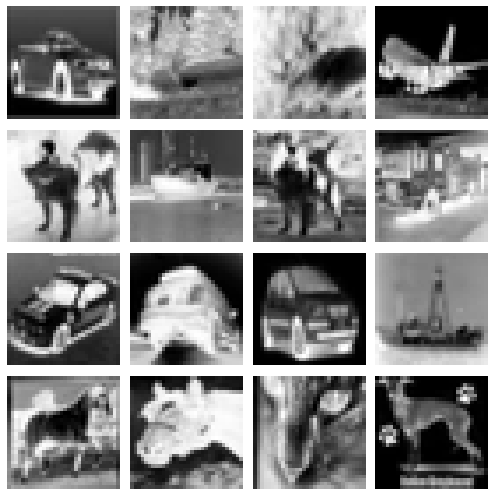

In [6]:
index = np.random.choice(X_train.shape[0],16)
samples = X_train[index,:,:,:]
plt.figure(figsize=(7,7))
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img,interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
label_values = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

Image index: 3487
Label index: 7
Label: Horse


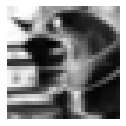

In [8]:
index = np.random.choice(X_train.shape[0],1)
print("Image index:", index[0])
print("Label index:", Y_train[index][0][0])
label_index = Y_train[index][0][0]
print("Label:", label_values[label_index])
samples = X_train[index,:,:,:]
plt.figure(figsize=(7,7))
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img,interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Normalizo las imágenes

In [9]:
print(np.min(X_train), np.max(X_train))

0 255


In [10]:
x_pixels = X_train.astype('float32')
print(np.min(x_pixels), np.max(x_pixels))
x_pixels = x_pixels - 127.5
print(np.min(x_pixels), np.max(x_pixels))
x_pixels /= 127.5
print(np.min(x_pixels), np.max(x_pixels))
X_train = x_pixels

0.0 255.0
-127.5 127.5
-1.0 1.0


In [11]:
print(np.min(X_train), np.max(X_train))

-1.0 1.0


In [12]:
print(np.min(Y_train), np.max(Y_train))

0 9


In [13]:
Y_train = Y_train.reshape(-1, 1)

In [14]:
print(np.min(Y_train), np.max(Y_train))

0 9


In [16]:
print('Shape de X_train:', X_train.shape)
print('Cantidad de muestras:',X_train.shape[0])

Shape de X_train: (60000, 32, 32, 3)
Cantidad de muestras: 60000


In [17]:
print('Shape de Y_train:', Y_train.shape)
print('Cantidad de muestras:',Y_train.shape[0])

Shape de Y_train: (60000, 1)
Cantidad de muestras: 60000


## Train settings

In [18]:
img_size = 32
noise_size = 2048
batch_size = 50
classes = 10

## Generator

In [20]:
noise = Input(shape=(noise_size, ))
label = Input(shape=(1, ))
label_embedding = Flatten()(Embedding(classes, noise_size)(label))
model_input = multiply([noise, label_embedding])

x = Dense(2048)(model_input)
x = Reshape((2, 2, 512))(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.1)(x)
x = Conv2DTranspose(256, (5, 5), padding='same', strides=2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.1)(x)
x = Conv2DTranspose(128, (5, 5), padding='same', strides=2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.1)(x)
x = Conv2DTranspose(64, (5, 5), padding='same', strides=2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.1)(x)
x = Conv2DTranspose(3, (5, 5), padding='same', strides=2)(x)
img = Activation('tanh')(x)
generator = Model([noise, label], img, name='generator')
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
generator.summary()
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 2048)      20480       input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 2048)         0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_2

## Discriminator

In [21]:
img = Input(shape=(img_size, img_size, 3))

x = GaussianNoise(0.1)(img)
x = Conv2D(64, (3, 3), padding='same', strides = 2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(128, (3, 3), padding='same', strides = 2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(256, (3, 3), padding='same', strides = 2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(512, (3, 3), padding='same', strides = 2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
label = Input(shape=(1, ))
label_embedding = Flatten()(Embedding(classes, noise_size)(label))
flat_img = Flatten()(x)
model_input = multiply([flat_img, label_embedding])
nn = Dropout(0.3)(model_input)
validity = Dense(1, activation='sigmoid')(nn)
discriminator = Model([img, label], validity, name='discriminator')
discriminator.compile(loss=['binary_crossentropy'], optimizer=Adam(lr=0.0002, beta_1=0.5))
discriminator.summary()
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 32, 32, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   1792        gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

## Juntar modelos de Generador y Discriminador para generar GAN

In [22]:
# Congelo los pesos del discriminador
discriminator.trainable = False

noise = Input(shape=(noise_size, ))
label = Input(shape=(1, ))
img = generator([noise, label])
valid = discriminator([img, label])

GAN = Model([noise, label], valid, name='gan')
GAN.compile(loss=['binary_crossentropy'], optimizer=Adam(lr=0.0002, beta_1=0.5))
GAN.summary()
plot_model(GAN, to_file='combined_plot.png', show_shapes=True, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    8526723     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            1577345     generator[1][0]                  
          

## Pre train

In [23]:
# Número de iteraciones
ntrain = 6000
# Tomo datos al azar para entrenar
trainidx = np.random.choice(X_train.shape[0], ntrain)
labels_train = Y_train[trainidx]
print("labels_train", labels_train.shape)
images_train = X_train[trainidx,:,:,:]
print("images_train", images_train.shape)

# Pre-entrenar al discriminador
#Genero ruido
noise = np.random.randn(ntrain, noise_size)

#Tomo labels random
labels_sample = np.random.randint(0, 10, ntrain).reshape(-1, 1)
print("labels_sample", labels_sample.shape)

#Genero imágenes con el generador a partir del ruido
generated_images = generator.predict([noise, labels_sample])
print("images_sample", generated_images.shape)

#Junto las imágenes generadas con las originales del dataset
labels_concat = np.concatenate((labels_train, labels_sample))
images_concat = np.concatenate((images_train, generated_images))
print("labels_concat", labels_concat.shape)
print("images_concat", images_concat.shape)

#Trato de engañar al discriminador diciendo que todas las imágenes son reales
valid = np.zeros((labels_concat.shape[0], 1)) - (np.random.random()*0.1)
print("valid", valid.shape)

#Permito cambiar los pesos del discriminador
discriminator.trainable = True

#Pre-entreno
discriminator.fit([images_concat, labels_concat], valid, epochs=1, batch_size=32)

labels_train (6000, 1)
images_train (6000, 32, 32, 3)
labels_sample (6000, 1)
images_sample (6000, 32, 32, 3)
labels_concat (12000, 1)
images_concat (12000, 32, 32, 3)
valid (12000, 1)
Epoch 1/1
12000/12000 [==============================] - 72s 6ms/step - loss: 0.0046


In [24]:
#Predigo
y_hat = discriminator.predict([images_concat, labels_concat])

#Analizo los resultados del discriminador pre-entrenado
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(valid,axis=1)
diff = y_idx-y_hat_idx
n_tot = valid.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Precisión: %0.02f imágenes (%d de %d) correctas"%(acc, n_rig, n_tot))

Precisión: 100.00 imágenes (12000 de 12000) correctas


## Train process

In [25]:
def train(epochs):
    
    for epoch in tqdm(range(epochs)):
        
        random = np.random.randint(0, 11)
        
        for index in range(int(images.shape[0]/batch_size)):
            print(index, "in", int(images.shape[0]/batch_size))         
                
            valid = np.ones((batch_size, 1)) - (np.random.random()*0.1)
            fake = np.zeros((batch_size, 1)) + (np.random.random()*0.1)
            
            x_train = images[index*batch_size : (index+1)*batch_size]
            y_train = labels[index*batch_size : (index+1)*batch_size]
            x_train = (x_train - 127.5)/127.5
            
            if index % 100 == random:
                valid = np.zeros((batch_size, 1)) + (np.random.random()*0.1)
                fake = np.ones((batch_size, 1)) - (np.random.random()*0.1)
            
            noise = np.random.randn(batch_size, noise_size)
            gen_img = generator.predict([noise, y_train])
                        
            d_loss_real = discriminator.train_on_batch([x_train, y_train], valid)
            d_loss_fake = discriminator.train_on_batch([gen_img, y_train], fake)
            d_loss = 0.5*(np.add(d_loss_real, d_loss_fake))

            sample_label = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            valid = np.ones((batch_size, 1))
            
            g_loss = GAN.train_on_batch([noise, sample_label], valid)

            if index % (batch_size) == 0:
                print(index)
                print("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss, g_loss))
                sample_images(epoch)
                # Actualizo las gráficas cada plt_frq iteraciones
            
            losses["g"].append(g_loss)
            losses["d"].append(d_loss)
            
        plot_loss(losses)
                
        name = './weights/gan_' + str(epoch) + '.h5'
        GAN.save_weights(name)
        
        time.sleep(30)
        
    generator.save('saved models/cgan_generator_model_1.h5')
    discriminator.save('saved models/cgan_discriminator_model_1.h5')
    GAN.save('saved models/cgan_model_1.h5')

## Generate sample images

In [26]:
def sample_images(epoch):
    r = 2
    c = 5
    noise = np.random.randn(10, noise_size)
    sample_label = np.arange(0, 10).reshape(-1, 1)
            
    gen_img = generator.predict([noise, sample_label])
        
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            img = image.array_to_img(gen_img[cnt])
            axs[i,j].imshow(img)
            axs[i,j].set_title("Class: %d" % sample_label[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

## Plot loss from training

In [27]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='Pérdida del discriminador')
        plt.plot(losses["g"], label='Pérdida del generador')
        plt.legend()
        plt.show()

In [28]:
losses = {"d":[], "g":[]}

## Train!

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

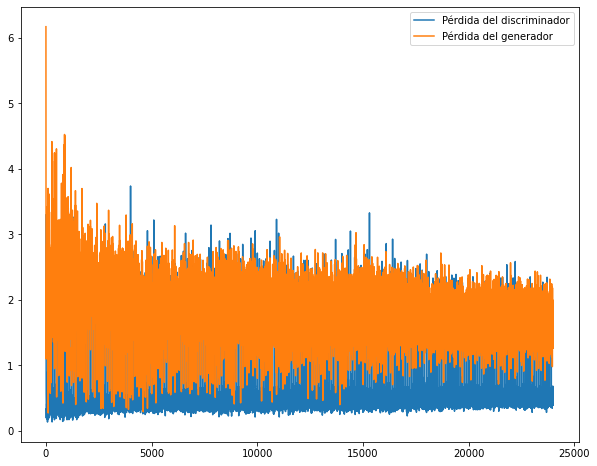

100%|██████████| 20/20 [14:40:59<00:00, 2642.96s/it]


In [29]:
train(epochs=20)

In [30]:
generator.save('saved models/cgan_generator_model_1.h5')
discriminator.save('saved models/cgan_discriminator_model_1.h5')
GAN.save('saved models/cgan_model_1.h5')

In [31]:
labels = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

In [32]:
labels[0]

'Airplane'

In [33]:
def predict():
    r = 2
    c = 5
    noise = np.random.randn(10, noise_size)
    sample_label = np.arange(0, 10).reshape(-1, 1)
            
    gen_img = generator.predict([noise, sample_label])
        
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            img = image.array_to_img(gen_img[cnt])
            axs[i,j].imshow(img)
            #axs[i,j].set_title("Class: %d" % sample_label[cnt])
            axs[i,j].set_title(labels[sample_label[cnt][0]])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()        
    plt.close()

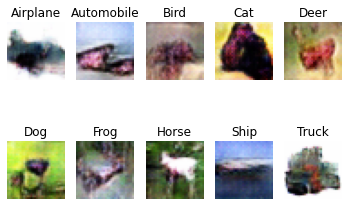

In [34]:
predict()

In [35]:
def predictOne(label=1):
    noise = np.random.randn(9, noise_size)
    sample_label = np.arange(0, 9).reshape(-1, 1)
    gen_img = generator.predict([noise, sample_label])
    img = image.array_to_img(gen_img[label])
    plt.imshow(img)
    print(labels[sample_label[label][0]])
    plt.axis('off')
    plt.show()        
    plt.close()

Automobile


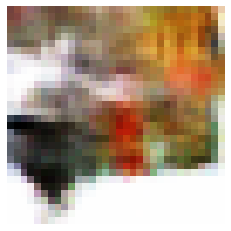

In [36]:
predictOne()

In [37]:
#Predigo
y_hat = discriminator.predict([images_concat, labels_concat])

#Analizo los resultados del discriminador pre-entrenado
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(valid,axis=1)
diff = y_idx-y_hat_idx
n_tot = valid.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Precisión: %0.02f imágenes (%d de %d) correctas"%(acc, n_rig, n_tot))

Precisión: 100.00 imágenes (12000 de 12000) correctas


(10, 2048)
(10, 1)


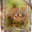

In [39]:
from keras.models import load_model
label=3
cgan_loaded = load_model('saved models/cgan_generator_model_1.h5')
noise_size = 2048
noise = np.random.randn(10, noise_size)
sample_label = np.arange(0, 10).reshape(-1, 1)
print(noise.shape)
print(sample_label.shape)
gen_img = cgan_loaded.predict([noise, sample_label])
img = image.array_to_img(gen_img[label])
img

In [2]:
print(keras.__version__)

2.1.5


In [3]:
import tensorflow as tf
print(tf.__version__)

1.7.0
